# Feature Extraction

This notebook goes through the feature extraction pipeline:

- data import and event class instantiation
- image preprocessing
- feature extraction

In [1]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import sys
import os

print("Current working directory: ", os.getcwd())
sys.path.append(os.path.abspath('../ANN-code'))

from bb_event import load_events_bb, Event
from image_preprocessing import gaussian_smoothing, noise_adder, smoothing_widget, image_threshold_widget
from image_analysis import plot_axis
from feature_extraction import extract_energy_deposition, extract_max_pixel_intensity, extract_axis
from data_methods import create_file_paths


from ipywidgets import interact
from ipywidgets import interact, FloatSlider
from scipy.interpolate import splprep, splev


Current working directory:  /Users/benstevens/MIGDAL/NR-ANN/notebooks


## Data import

In [ ]:
# set random seed
np.random.seed(2)

# choose data path
data_path = ["../ANN-code/Data/im0"]
# data_path = ["../../../../tmarley/GEM_ITO/run/im0"
#              "../../../../tmarley/GEM_ITO/run/im1/C",
#              "../../../../tmarley/GEM_ITO/run/im1/F",
#              "../../../../tmarley/GEM_ITO/run/im2",
#              "../../../../tmarley/GEM_ITO/run/im3",
#              "../../../../tmarley/GEM_ITO/run/im4",]

file_paths = create_file_paths(data_path)
events = []

# take only 1000 images
file_paths = np.random.choice(file_paths, size=1000, replace=True)
for file in file_paths:
    events.append(Event(file, np.load(file)))

print("Number of events loaded: ", len(events))

100%|██████████| 2017/2017 [00:00<00:00, 1110078.88it/s]


Number of events loaded:  1000


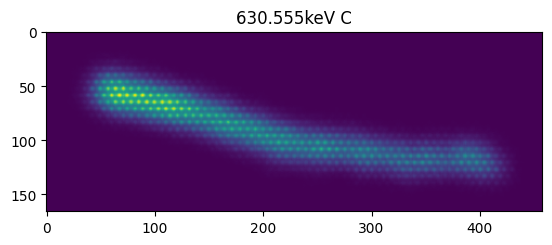

In [43]:
# sample random event
event = np.random.choice(events, 1, replace=True)[0]

# plot image before processing
event.plot_image()

## Image preprocessing

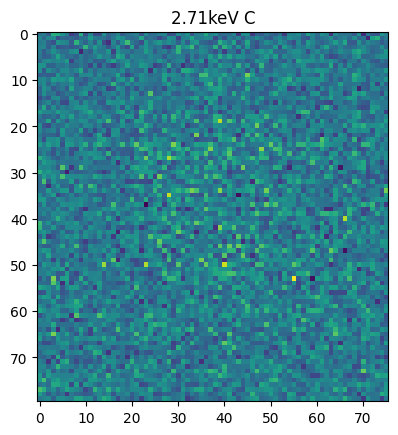

In [34]:
# add noise to image

# import master_dark, example_dark_list

dark_dir = "../ANN-code/Data/darks"
dark_list_number = 0 
m_dark = np.load(f"{dark_dir}/master_dark_1x1.npy")
example_dark_list = np.load(
    f"{dark_dir}/quest_std_dark_{dark_list_number}.npy"
)

event.image = noise_adder(event.image, m_dark, example_dark_list)

# plot noisy image
event.plot_image()

# this is now how an event would look realistically(ish)

Here is a widget to look at smoothing

In [3]:
unsmoothed_image = event.image.copy()

# Interactive widget to vary smoothing_sigma
def interactive_smoothing(sigma):
    smoothing_widget(unsmoothed_image, sigma)

# Create the slider and link it to the function
interact(interactive_smoothing, sigma=widgets.FloatSlider(value=1.0, min=0.0, max=10.0, step=0.1, description="Smoothing σ"))

interactive(children=(FloatSlider(value=1.0, description='Smoothing σ', max=10.0), Output()), _dom_classes=('w…

<function __main__.interactive_smoothing(sigma)>

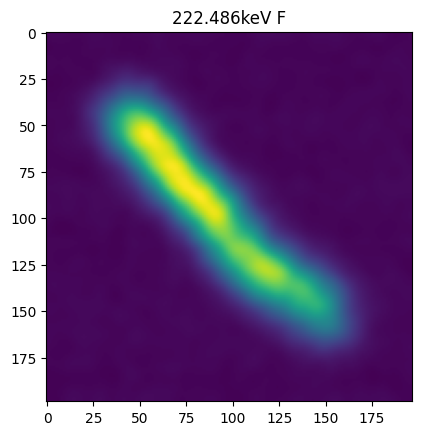

In [4]:
# using a fixed sigma value

sigma = 3.5
event.image = gaussian_smoothing(event.image, sigma)

# plot smoothed image
event.plot_image()

In [5]:
# threshold widget test

def interactive_image_threshold(event_image):
    """
    Creates an interactive widget to vary the threshold percentile for an image.

    Parameters:
    ----------
    event_image : np.ndarray
        The image from the Event object to threshold.
    """

    interact(
        lambda threshold_percentile: image_threshold_widget(event_image, threshold_percentile),
        threshold_percentile=FloatSlider(value=95, min=0, max=100, step=1, description="Percentile")
    )


interactive_image_threshold(event.image)


interactive(children=(FloatSlider(value=95.0, description='Percentile', step=1.0), Output()), _dom_classes=('w…

Demonstrates the functionality of thresholding to get more accurate intensity and other features. however this requires a choice of fixed percentile which is not natural for all of the energy range. therefore we don't use this for feature extraction yet

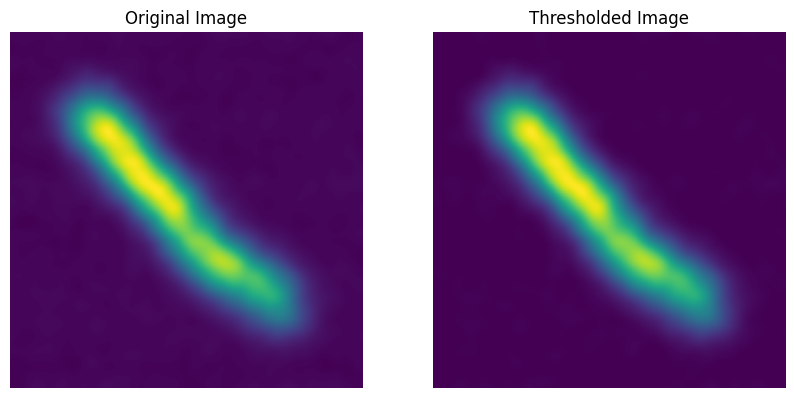

In [6]:
# threshold with fixed percentile
threshold_percentile = 50

threshold = np.percentile(event.image, threshold_percentile)
thresholded_image = np.where(event.image > threshold, event.image, 0)

# plot thresholded image next to original
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(event.image, cmap="viridis")
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(thresholded_image, cmap="viridis")
ax[1].set_title("Thresholded Image")
ax[1].axis("off")
plt.show()



## Feature extraction

In [7]:
# save the processed image as a png (if needed)
plt.imsave("processed_event.png", event.image, cmap="viridis")


In [8]:
# first consider simple features 
# extracting with the image after it has had noise added and smoothed.

total_energy = extract_energy_deposition(event.image)
max_intensity = extract_max_pixel_intensity(event.image)

print(f"Total energy deposition: {total_energy}")
print(f"Max pixel intensity: {max_intensity}")

Total energy deposition: 687561.4688110355
Max pixel intensity: 165.873257640293


Principal axis: [0.68738358 0.72629458]


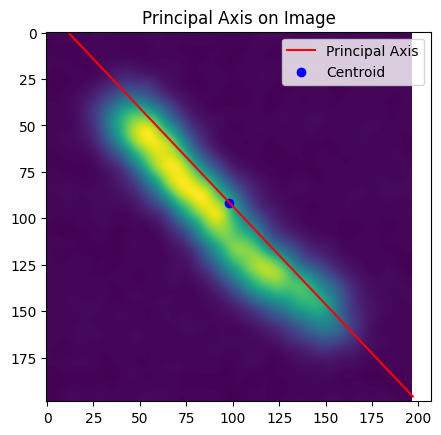

In [9]:
# finding principal axis using SVD
# extract axis and centroid

axis, centroid = extract_axis(event.image, method="eigen")
print(f"Principal axis: {axis}")

# plot image with principal axis
plot_axis(event.image, axis, centroid)








